# SafeNSound: Initial Log Scaled Mel-Spectrogram Development

In [26]:
import os
import joblib

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
import librosa as lb
# import librosa.display as ld
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
# import sounddevice as sd
from sklearn.model_selection import train_test_split

In [27]:
ENVIRONMENT_PATH = os.path.join("..", "..", "noise_dataset", "environment")
DEFENSIVE_PATH = os.path.join("..", "..", "noise_dataset", "speech_defensive")
HOSTILE_PATH = os.path.join("..", "..", "noise_dataset", "speech_hostile")


def load_audio_files(directory, filename):
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} does not exist.")

    if filename.endswith('.wav'):
        file_path = os.path.join(directory, filename)
        try:
            wav, sr = lb.load(file_path, sr=16000, mono=True)
            ##wav = tf.convert_to_tensor(wav, dtype=tf.float32)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return wav, sr


In [28]:
def log_scaled_melspectrogram(audio, sample_rate, hop_length=200, frame_ms=25, n_mels=64, max_len=320):
    frame_length = int(sample_rate * frame_ms / 1000)
    n_fft = 1 << (frame_length - 1).bit_length()

    melspectrogram = lb.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    melS_dB = lb.power_to_db(melspectrogram, ref=np.max)

    if melS_dB.shape[1] < max_len:
        melS_dB = np.pad(melS_dB, ((0,0),(0, max_len - melS_dB.shape[1])), mode='constant')
    else:
        melS_dB = melS_dB[:, :max_len]

    S_norm = (melS_dB - melS_dB.mean()) / (melS_dB.std() + 1e-6)
    # melS_dB = melS_dB[..., np.newaxis]
    delta = lb.feature.delta(S_norm)
    delta2 = lb.feature.delta(S_norm, order=2)

    features = np.stack([S_norm, delta, delta2], axis=-1).astype(np.float32)

    return features

In [29]:
def augment_audio(audio, sample_rate):
    augmented = [audio]

    audio_stretched = lb.effects.time_stretch(audio, rate=0.8)
    augmented.append(audio_stretched)

    noise = np.random.normal(0, 0.003, audio.shape)
    audio_noise = audio + noise
    augmented.append(audio_noise)
    
    audio_high_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=2)
    audio_low_pitch = lb.effects.pitch_shift(audio, sr=sample_rate, n_steps=-2)
    augmented.append(audio_high_pitch)
    augmented.append(audio_low_pitch)

    noise_bg = np.random.normal(0, 0.001, audio.shape)
    audio_bg = audio + noise_bg
    augmented.append(audio_bg)

    audio_quiet = audio*0.7
    audio_loud = audio*1.3
    augmented.append(audio_quiet)
    augmented.append(audio_loud)

    return augmented

In [30]:
X = []
y = []
emergency_labels = {"hostile": 2, "defensive": 1, "environment": 0}
file_label_pairs = []

for label, idx in emergency_labels.items():
    main_path = HOSTILE_PATH if label == "hostile" else DEFENSIVE_PATH if label == "defensive" else ENVIRONMENT_PATH if label == "environment" else None
    if main_path is None:
        print(f"Warning: No valid path for label {label}. Skipping...")
        continue

    folder = f"{main_path}"

    if not os.path.exists(folder):
        print(f"Warning: Directory {folder} does not exist. Skipping...")
        continue

    for file in os.listdir(folder):
        if file.endswith(".wav"):
            file_label_pairs.append((os.path.join(folder, file), idx))
            
paths = [p for p,_ in file_label_pairs]
labs  = [l for _,l in file_label_pairs]

In [31]:
train_paths, temp_paths, train_labs, temp_labs = train_test_split(paths, labs, test_size=0.3, stratify=labs, random_state=42)
val_paths, test_paths, val_labs, test_labs = train_test_split(temp_paths, temp_labs, test_size=0.5, stratify=temp_labs, random_state=42)

train_pairs = list(zip(train_paths, train_labs))
val_pairs   = list(zip(val_paths,  val_labs))
test_pairs  = list(zip(test_paths, test_labs))

In [32]:
def gen(pairs):
    for fp, idx in pairs:
        wav, sr = lb.load(fp, sr=16000, mono=True)
        for aug in augment_audio(wav, sr):
            feat = log_scaled_melspectrogram(aug, sr)
            yield feat, keras.utils.to_categorical(idx, num_classes=3)

In [33]:
spec = (tf.TensorSpec(shape=(64, 320, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(3,), dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(lambda: gen(train_pairs), output_signature=spec)\
                        .shuffle(1024).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_generator(lambda: gen(val_pairs), output_signature=spec)\
                        .batch(32).prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_generator(lambda: gen(test_pairs), output_signature=spec)\
                        .batch(32).prefetch(tf.data.AUTOTUNE)

In [34]:
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Conv Block 2
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),

        # Flatten + Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [35]:
input_shape = (64, 320, 3) #nmel, max_len, channels
model = build_cnn(input_shape, num_classes=3)
model.summary()

c:\Users\Acer\Documents\GitHub\SafeNSound-An-IoT-Based-Distress-Signals-Detection-for-Semi-private-Rooms-using-Sound-Sensor\myenv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 320, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 320, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 160, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32, 160, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 160, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 160, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 80, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 80, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 40, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 8, 40, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 40960)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     5,243,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,337,539 (20.36 MB)

 Trainable params: 5,337,091 (20.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
history = model.fit(train_ds, epochs=7, validation_data=val_ds)
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

Epoch 1/7
    145/Unknown 494s 3s/step - accuracy: 0.7718 - loss: 2.7118

c:\Users\Acer\Documents\GitHub\SafeNSound-An-IoT-Based-Distress-Signals-Detection-for-Semi-private-Rooms-using-Sound-Sensor\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


145/145 ━━━━━━━━━━━━━━━━━━━━ 568s 4s/step - accuracy: 0.8244 - loss: 1.1204 - val_accuracy: 0.1643 - val_loss: 25.3976
Epoch 2/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 561s 4s/step - accuracy: 0.9020 - loss: 0.2539 - val_accuracy: 0.1875 - val_loss: 8.0265
Epoch 3/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 560s 4s/step - accuracy: 0.9314 - loss: 0.1829 - val_accuracy: 0.5484 - val_loss: 4.0607
Epoch 4/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9410 - loss: 0.1738 - val_accuracy: 0.8730 - val_loss: 0.3347
Epoch 5/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.9602 - loss: 0.1228 - val_accuracy: 0.9375 - val_loss: 0.3714
Epoch 6/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 546s 4s/step - accuracy: 0.9559 - loss: 0.1259 - val_accuracy: 0.9325 - val_loss: 0.2665
Epoch 7/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.9669 - loss: 0.1166 - val_accuracy: 0.9456 - val_loss: 0.3899
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 436ms/step - accuracy: 0.9220 - loss: 0.4017
Test accuracy: 0.921999990940094


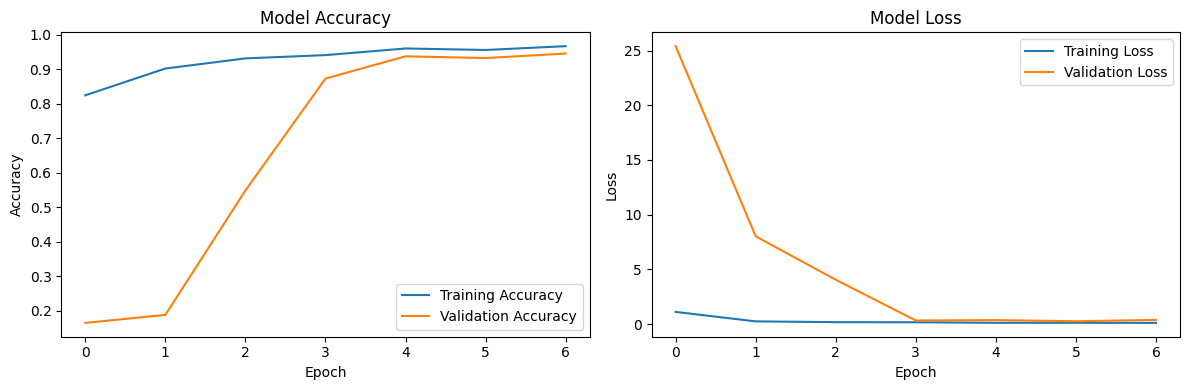

In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [38]:
model.save('lsms_cnn_model.keras')

In [39]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,  # Use older compatible ops
]
tflite_model = converter.convert()

# Save the new model
with open("lsms_cnn_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Acer\AppData\Local\Temp\tmp38guh3c3\assets


INFO:tensorflow:Assets written to: C:\Users\Acer\AppData\Local\Temp\tmp38guh3c3\assets


Saved artifact at 'C:\Users\Acer\AppData\Local\Temp\tmp38guh3c3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 320, 3), dtype=tf.float32, name='keras_tensor_34')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2583297646560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263605984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263600352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263605104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2584506840896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263601056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263604224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263601584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263885216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582263887504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2582